# Fine tune a checkpoint of MedSAM on point prompted Data

Given a path to a MedSAM checkpoint, we want to fine tune it on pre-processed data
(subject to modifications specified by the paper and the transformation script). This will
be done initially on an anatomy-specific level.

## Argparse Setup

In [22]:
# Imports
import re
import os
import cv2
import sys
import json
import torch
import monai
import random
import argparse
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from time import time, sleep
from datetime import datetime
from skimage import transform
from matplotlib import pyplot as plt
from segment_anything import sam_model_registry
from torch.utils.data import Dataset, DataLoader

# Add the setup_data_vars function as we will need it to find the directory for the training data.
dir1 = os.path.abspath(os.path.join(os.path.abspath(''), '..', '..'))
if not dir1 in sys.path: sys.path.append(dir1)

from utils.environment import setup_data_vars
setup_data_vars()

In [23]:
parser = argparse.ArgumentParser()

# Inspired by orginal code from the MedSAM/extensions/point_prompt

# 1. Add the anatomy on which we will fine-tune
parser.add_argument(
    '--anatomy',
    type=str,
    help='Anatomy on which to fine-tune the model. Note: this is case sensitive, please capitalize the first letter and accronyms such as CTVn or CTVp.',
    required=True
)

# 1.2 Add the model training type
parser.add_argument(
    '--model_training',
    type=str,
    help='Determines the type of model that is being trained. For example, if the model uses only points, the argument should be "point". If the model uses both points and bounding boxes, the argument should be "point_bbox".',
    required=True,
)

# 2. Path to the MedSAM checkpoint
parser.add_argument(
    '--checkpoint',
    type=str,
    help='Path to the checkpoint of the model to fine-tune',
    default=os.path.join(os.environ['PROJECT_DIR'], 'models', 'MedSAM', 'work_dir', 'MedSAM', 'medsam_vit_b.pth'),
    required=False
)

# 3. Path where we will be saving the checkpoints of the fine-tuned model
parser.add_argument(
    '--save_dir',
    type=str,
    help='Directory where the fine-tuned model will be saved',
    required=False,
    default=os.environ.get('MedSAM_finetuned')
)

# 4. Add the source directory for the data
parser.add_argument(
    '--img_dir',
    type=str,
    help='Directory containing the images for the slices of the anatomy',
    required=False,
)

# 5. Add the source directory for the gts
parser.add_argument(
    '--gt_dir',
    type=str,
    help='Directory containing the ground truth masks for the slices of the anatomy',
    required=False
)

# 6. Number of epochs for the fine-tuning
parser.add_argument(
    '--epochs',
    type=int,
    help='Number of epochs for the fine-tuning',
    required=False,
    default=300
)

# 7. Batch size for the fine-tuning
parser.add_argument(
    '--batch_size',
    type=int,
    help='Batch size for the fine-tuning',
    required=False,
    default=8
)

parser.add_argument(
    '--batches_per_epoch',
    type=int,
    help='Number of batches per epoch',
    required=False,
)

# 8. Learning rate for the fine-tuning
parser.add_argument(
    '--lr',
    type=float,
    help='Learning rate for the fine-tuning',
    required=False,
    default=0.00005
)

# 9. Number of workers for the data loader
parser.add_argument(
    '--num_workers',
    type=int,
    help='Number of workers for the data loader',
    required=False,
    default=16
)

parser.add_argument(
    '--weight_decay',
    type=float,
    help='Weight decay for the optimizer',
    required=False,
    default=0.01
)

# 11. Resume checkpoint
parser.add_argument(
    '--resume',
    type=bool,
    help='Whether to resume training using the latest checkpoint in the save_dir',
    required=False,
    default=True
)

parser.add_argument(
    '--lowres',
    type=bool,
    help='A flag for setting the source of the data. For now, if the flag is set to True, the data will be loaded from the lowres directory. Otherwise, we load it from the pure pre-processed directory.',
    required=False,
    default=True
)

_StoreAction(option_strings=['--lowres'], dest='lowres', nargs=None, const=None, default=True, type=<class 'bool'>, choices=None, required=False, help='A flag for setting the source of the data. For now, if the flag is set to True, the data will be loaded from the lowres directory. Otherwise, we load it from the pure pre-processed directory.', metavar=None)

In [24]:
print('Preparing to parse args!')

Preparing to parse args!


In [25]:
# args = parser.parse_args()
# Suppose for now we get the following set of required arguments:
args = parser.parse_args([
    '--anatomy', 'CTVn',
    '--model_training', 'boxed_lowres',
#     # '--checkpoint', os.path.join(os.environ['PROJECT_DIR'], 'models', 'MedSAM', 'work_dir', 'MedSAM', 'medsam_vit_b.pth'),
#     # '--save_dir', os.path.join(os.environ['MedSAM_finetuned']),
    '--epochs', '100',
    '--batch_size', '9',
    '--batches_per_epoch', '100', 
    '--lowres', 'True',
])

## Set up the vars

In [26]:
anatomy = args.anatomy
checkpoint_path = args.checkpoint
save_dir = args.save_dir
img_dir = args.img_dir
gt_dir = args.gt_dir
epochs = args.epochs
batch_size = args.batch_size
lr = args.lr
num_workers = args.num_workers
weight_decay = args.weight_decay
resume = args.resume
batches_per_epoch = args.batches_per_epoch
model_training = args.model_training
lowres = args.lowres

if img_dir is None:
    img_dir = os.environ['MedSAM_preprocessed_lowres'] if lowres else os.environ['MedSAM_preprocessed']
    img_dir = os.path.join(img_dir, 'imgs')
if gt_dir is None:
    gt_dir = os.environ['MedSAM_preprocessed_lowres'] if lowres else os.environ['MedSAM_preprocessed']
    gt_dir = os.path.join(gt_dir, 'gts', anatomy)

assert not lowres or ('lowres' in img_dir and 'lowres' in gt_dir) , 'Please make sure that the lowres flag is set correctly!'

save_dir = os.path.join(save_dir, model_training, anatomy)

# print all the args
print('Arguments:')
print(f'anatomy {anatomy}')
print(f'checkpoint {checkpoint_path}')
print(f'save_dir {save_dir}')
print(f'img_dir {img_dir}')
print(f'gt_dir {gt_dir}')
print(f'epochs {epochs}')
print(f'batch_size {batch_size}')
print(f'lr {lr}')
print(f'num_workers {num_workers}')
print(f'weight_decay {weight_decay}')
print(f'resume {resume}')
print(f'batches_per_epoch {batches_per_epoch}')
print(f'model_training {model_training}')
print(f'lowres {lowres}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Arguments:
anatomy CTVn
checkpoint /vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/models/MedSAM/work_dir/MedSAM/medsam_vit_b.pth
save_dir /vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/MedSAM_finetuned/boxed_lowres/CTVn
img_dir /vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/MedSAM_preprocessed_lowres/imgs
gt_dir /vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/MedSAM_preprocessed_lowres/gts/CTVn
epochs 100
batch_size 9
lr 5e-05
num_workers 16
weight_decay 0.01
resume True
batches_per_epoch 100
model_training boxed_lowres
lowres True


In [27]:
seed = 42

torch.cuda.empty_cache()
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [28]:
image_id_from_file_name_regex = r'.*_(\d+).*'
slice_id_from_file_name_regex = r'.*-(\d+).*'

## Set up Dataset class

In [29]:
from stocaching import SharedCache

# Adapted Dataset class from ../2_no_finetuning/MEDSAM_helper_functions.py
class SAM_Dataset(Dataset):
    """A torch dataset for delivering slices of any axis to a medsam model."""

    def __init__(self, img_path, gt_path, id_split, data_aug=False, max_points=5, box_padding=10, max_box_points=3):
        """
        Args:
            img_path (string): Path to the directory containing the images
            gt_path (string): Path to the directory containing the ground truth masks
            id_split (list): List of image ids to include in the dataset
        """

        self.root_img_path = img_path
        self.root_gt_path = gt_path
        self.id_split = id_split
        self.data_aug = data_aug
        self.max_points = max_points
        self.box_padding = box_padding
        self.max_box_points = max_box_points
        
        # Assume that axese 0 1 and 2 have been processed.
        filter_fn = lambda x : x.endswith('.npy') and int(re.search(image_id_from_file_name_regex, x).group(1)) in id_split
        self.axis0_imgs = list(filter(filter_fn, os.listdir(os.path.join(gt_path, 'axis0'))))
        self.axis1_imgs = list(filter(filter_fn, os.listdir(os.path.join(gt_path, 'axis1'))))
        self.axis2_imgs = list(filter(filter_fn, os.listdir(os.path.join(gt_path, 'axis2'))))

        self.cache = SharedCache(
            size_limit_gib=15,
            dataset_len=self.__len__(),
            # dataset_len = self.__len__() if batches_per_epoch is None else min(self.__len__(), batches_per_epoch),
            data_dims=(512,512),
            dtype=torch.float32
        )

    def __len__(self):
        return len(self.axis0_imgs) + len(self.axis1_imgs) + len(self.axis2_imgs)

    def __getitem__(self, idx):
        assert 0 <= idx < self.__len__(), f"Index {idx} is out of range for dataset of size {self.__len__()}"

        # Fetch the image and ground truth mask. For safety, we index the items around the
        # ground truth masks, so that if for some reason the images are misaligned we will
        # guarantee that we will fetch the correct image

        img_path, gt_path, img_name = self._get_image_and_gt_path(idx)

        img = self._load_image(img_path, idx) # (H, W, C)
        gt = self._load_gt(gt_path) # (H, W, C)

        # add data augmentation: random fliplr and random flipud
        if self.data_aug:
            if random.random() > 0.5:
                # img = np.ascontiguousarray(np.flip(img, axis=-1))
                gt = np.ascontiguousarray(np.flip(gt, axis=-1))
                img = img.flip(-1).contiguous()
                # gt = gt.flip(-1).contiguous()
            if random.random() > 0.5:
                # img = np.ascontiguousarray(np.flip(img, axis=-2))
                gt = np.ascontiguousarray(np.flip(gt, axis=-2))
                img = img.flip(-2).contiguous()
                # gt = gt.flip(-2).contiguous()
        
        coords = self._get_random_coord(gt)
        boxes = self._get_bounding_boxes(gt)

        # The output of the model is 256x256, and it is easier to reason about
        # constricting an image, rather than expanding the output back ot 1024x1024

        gt = cv2.resize(
            gt,
            (256, 256),
            interpolation=cv2.INTER_NEAREST
        )

        return {
            "image": img, # 3x1024x1024
            "gt2D": torch.tensor(gt[None, :,:]).long(), # 1x256x256
            "coords": torch.tensor(coords[None, ...]).float(),
            "boxes": torch.tensor(boxes[None, ...]).float(),
            "image_name": img_name
        }
    
    def _get_image_and_gt_path(self, idx):
        if idx < len(self.axis0_imgs):
            axis, gt_name = 0, self.axis0_imgs[idx]
        elif idx < len(self.axis0_imgs) + len(self.axis1_imgs):
            axis, gt_name = 1, self.axis1_imgs[idx - len(self.axis0_imgs)]
        else:
            axis, gt_name = 2, self.axis2_imgs[idx - len(self.axis0_imgs) - len(self.axis1_imgs)]

        image_id = int(re.search(image_id_from_file_name_regex, gt_name).group(1))
        slice_id = int(re.search(slice_id_from_file_name_regex, gt_name).group(1))

        img_name = f'CT_zzAMLART_{image_id:03d}-{slice_id:03d}.npy'
        
        img_path = os.path.join(self.root_img_path, f'axis{axis}', img_name)
        gt_path = os.path.join(self.root_gt_path, f'axis{axis}', gt_name)

        return img_path, gt_path, img_name
    
    def _get_random_coord(self, gt):
        # Select a random point. We will use this point to guide the model to segment the
        # anatomy. The idea is that we want to select the center of this shape with
        # greater probability than the outside of the shape.

        gt = np.uint8(gt > 0)
        y_indices, x_indices = np.where(gt > 0)

        # decide how many samples to draw from the segmentation area
        area = len(x_indices)
        # 1000 => 1
        # 5000 => 2
        # 10000 => 3
        # 15000 => 4
        n_samples = min(self.max_points, 1 + area // 5000)

        # Calculate the centroid of the segmentation
        centroid_x = np.mean(x_indices)
        centroid_y = np.mean(y_indices)

        # Calculate distances of each point from the centroid
        distances = np.sqrt((x_indices - centroid_x)**2 + (y_indices - centroid_y)**2)

        # Invert the distances to get higher probabilities for points closer to the
        # centroid
        inverse_distances = 1 / (distances + 1e-6)  # adding a small value to avoid division by zero

        # Normalize the probabilities
        probabilities = inverse_distances / np.sum(inverse_distances)

        # Sample a point based on the calculated probabilities
        index = np.random.choice(len(x_indices), p=probabilities, size=n_samples)

        x_point = x_indices[index]
        y_point = y_indices[index]

        # Determine how many times to repeat the existing coordinates
        repeat_times = self.max_points // len(x_point)

        # Repeat the existing coordinates
        x_repeat = np.tile(x_point, repeat_times)
        y_repeat = np.tile(y_point, repeat_times)

        # If the number of coordinates required is not divisible evenly by the existing coordinates
        # then we append the remaining coordinates from the existing ones
        remaining = self.max_points - len(x_repeat)
        x_repeat = np.concatenate((x_repeat, x_point[:remaining]))
        y_repeat = np.concatenate((y_repeat, y_point[:remaining]))

        # Reshape into an array of pairs of x, y coordinates
        coordinates = np.stack((x_repeat, y_repeat), axis=1)       

        return coordinates

    def _load_image(self, img_path, idx):
        # retrieve data from cache if it's there
        img = self.cache.get_slot(idx) # will be None if the cache slot was empty or OOB

        if img is None:
            img = np.load(img_path, 'r', allow_pickle=True) # (H, W, C) or (H, W) depending on the lowres flag

            if lowres:
                # Cache the image before we upsample it
                self.cache.set_slot(idx, torch.tensor(img).float())

                img = np.repeat(img[:, :, None], 3, axis=-1)
                img = transform.resize(
                    img,
                    (1024, 1024),
                    order=3,
                    preserve_range=True,
                    mode="constant",
                    anti_aliasing=True,
                )
                img = (img - img.min()) / np.clip(img.max() - img.min(), a_min=1e-8, a_max=None)  # normalize to [0, 1], (H, W, 3)

            img = np.transpose(img, (2, 0, 1)) # (C, H, W)
            assert np.max(img) <= 1. and np.min(img) >= 0., 'image should be normalized to [0, 1]'

            if not lowres:
                # If we have loaded in a full resolution image we need to cache it by first downsampling
                cached_img = cv2.resize(
                    img[0],
                    (512, 512),
                    interpolation=cv2.INTER_NEAREST
                )

                cached_img = torch.tensor(cached_img).float()

                self.cache.set_slot(idx, cached_img) # try to cache
        else:
            img = img.numpy()
            img = np.repeat(img[:, :, None], 3, axis=-1)
            img = transform.resize(
                img,
                (1024, 1024),
                order=3,
                preserve_range=True,
                mode="constant",
                anti_aliasing=True,
            )
            img = (img - img.min()) / np.clip(img.max() - img.min(), a_min=1e-8, a_max=None)  # normalize to [0, 1], (H, W, 3)

            assert np.max(img) <= 1. and np.min(img) >= 0., 'image should be normalized to [0, 1]'

            img = np.transpose(img, (2, 0, 1)) # (C, H, W)
            
        img = torch.tensor(img).float()
        return img

    def _load_gt(self, gt_path):
        # Loading of ground truth shouldn't be the limiting factor
        gt = np.load(gt_path, 'r', allow_pickle=True) # (H, W, C)

        if lowres:
            gt = transform.resize(
                gt,
                (1024, 1024),
                order=0,
                preserve_range=True,
                mode="constant",
                anti_aliasing=False,
            )
            gt = (gt > 0).astype(np.uint8)

        return gt

    def _get_bounding_boxes(self, gt):
        # Find contours in the segmentation map
        contours, _ = cv2.findContours(gt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Initialize list to store bounding boxes
        bounding_boxes = []

        # Loop through contours to find bounding boxes
        for contour in contours:
            # Get bounding box coordinates
            x, y, w, h = cv2.boundingRect(contour)
            bounding_boxes.append([x - self.box_padding, y - self.box_padding, x + w + self.box_padding, y + h + self.box_padding])  # Format: (x_min, y_min, x_max, y_max)

        # Adjust the number of bounding boxes if necessary
        if len(bounding_boxes) > self.max_box_points:
            # Sort bounding boxes based on area
            bounding_boxes = sorted(bounding_boxes, key=lambda bb: (bb[2] - bb[0]) * (bb[3] - bb[1]), reverse=True)
            bounding_boxes = bounding_boxes[:self.max_box_points]  # Select bounding boxes with the greatest area
        elif len(bounding_boxes) < self.max_box_points:
            # Repeat existing bounding boxes to fill in
            repeat_times = self.max_box_points // len(bounding_boxes)
            remaining = self.max_box_points % len(bounding_boxes)
            bounding_boxes = np.tile(bounding_boxes, (repeat_times, 1))
            # If the number of bounding boxes required is not divisible evenly by the existing ones,
            # then we append the remaining bounding boxes from the existing ones
            if remaining > 0:
                bounding_boxes = np.concatenate((bounding_boxes, bounding_boxes[:remaining]), axis=0)

        return np.array(bounding_boxes)

In [30]:
# quick test to see if the points are being generated correctly and transformations are also ok

from torchvision.utils import make_grid
import torch.nn.functional as F

experimental_datset = SAM_Dataset(img_dir, gt_dir, [i for i in range(1, 2)], data_aug=False)
dataloader = DataLoader(experimental_datset, batch_size=16, shuffle=True)

# Get a batch of examples
batch = next(iter(dataloader))

Dataset size (0.4 GiB) fits in cache limit (15 GiB). Allocating space to cache all 384 samples.


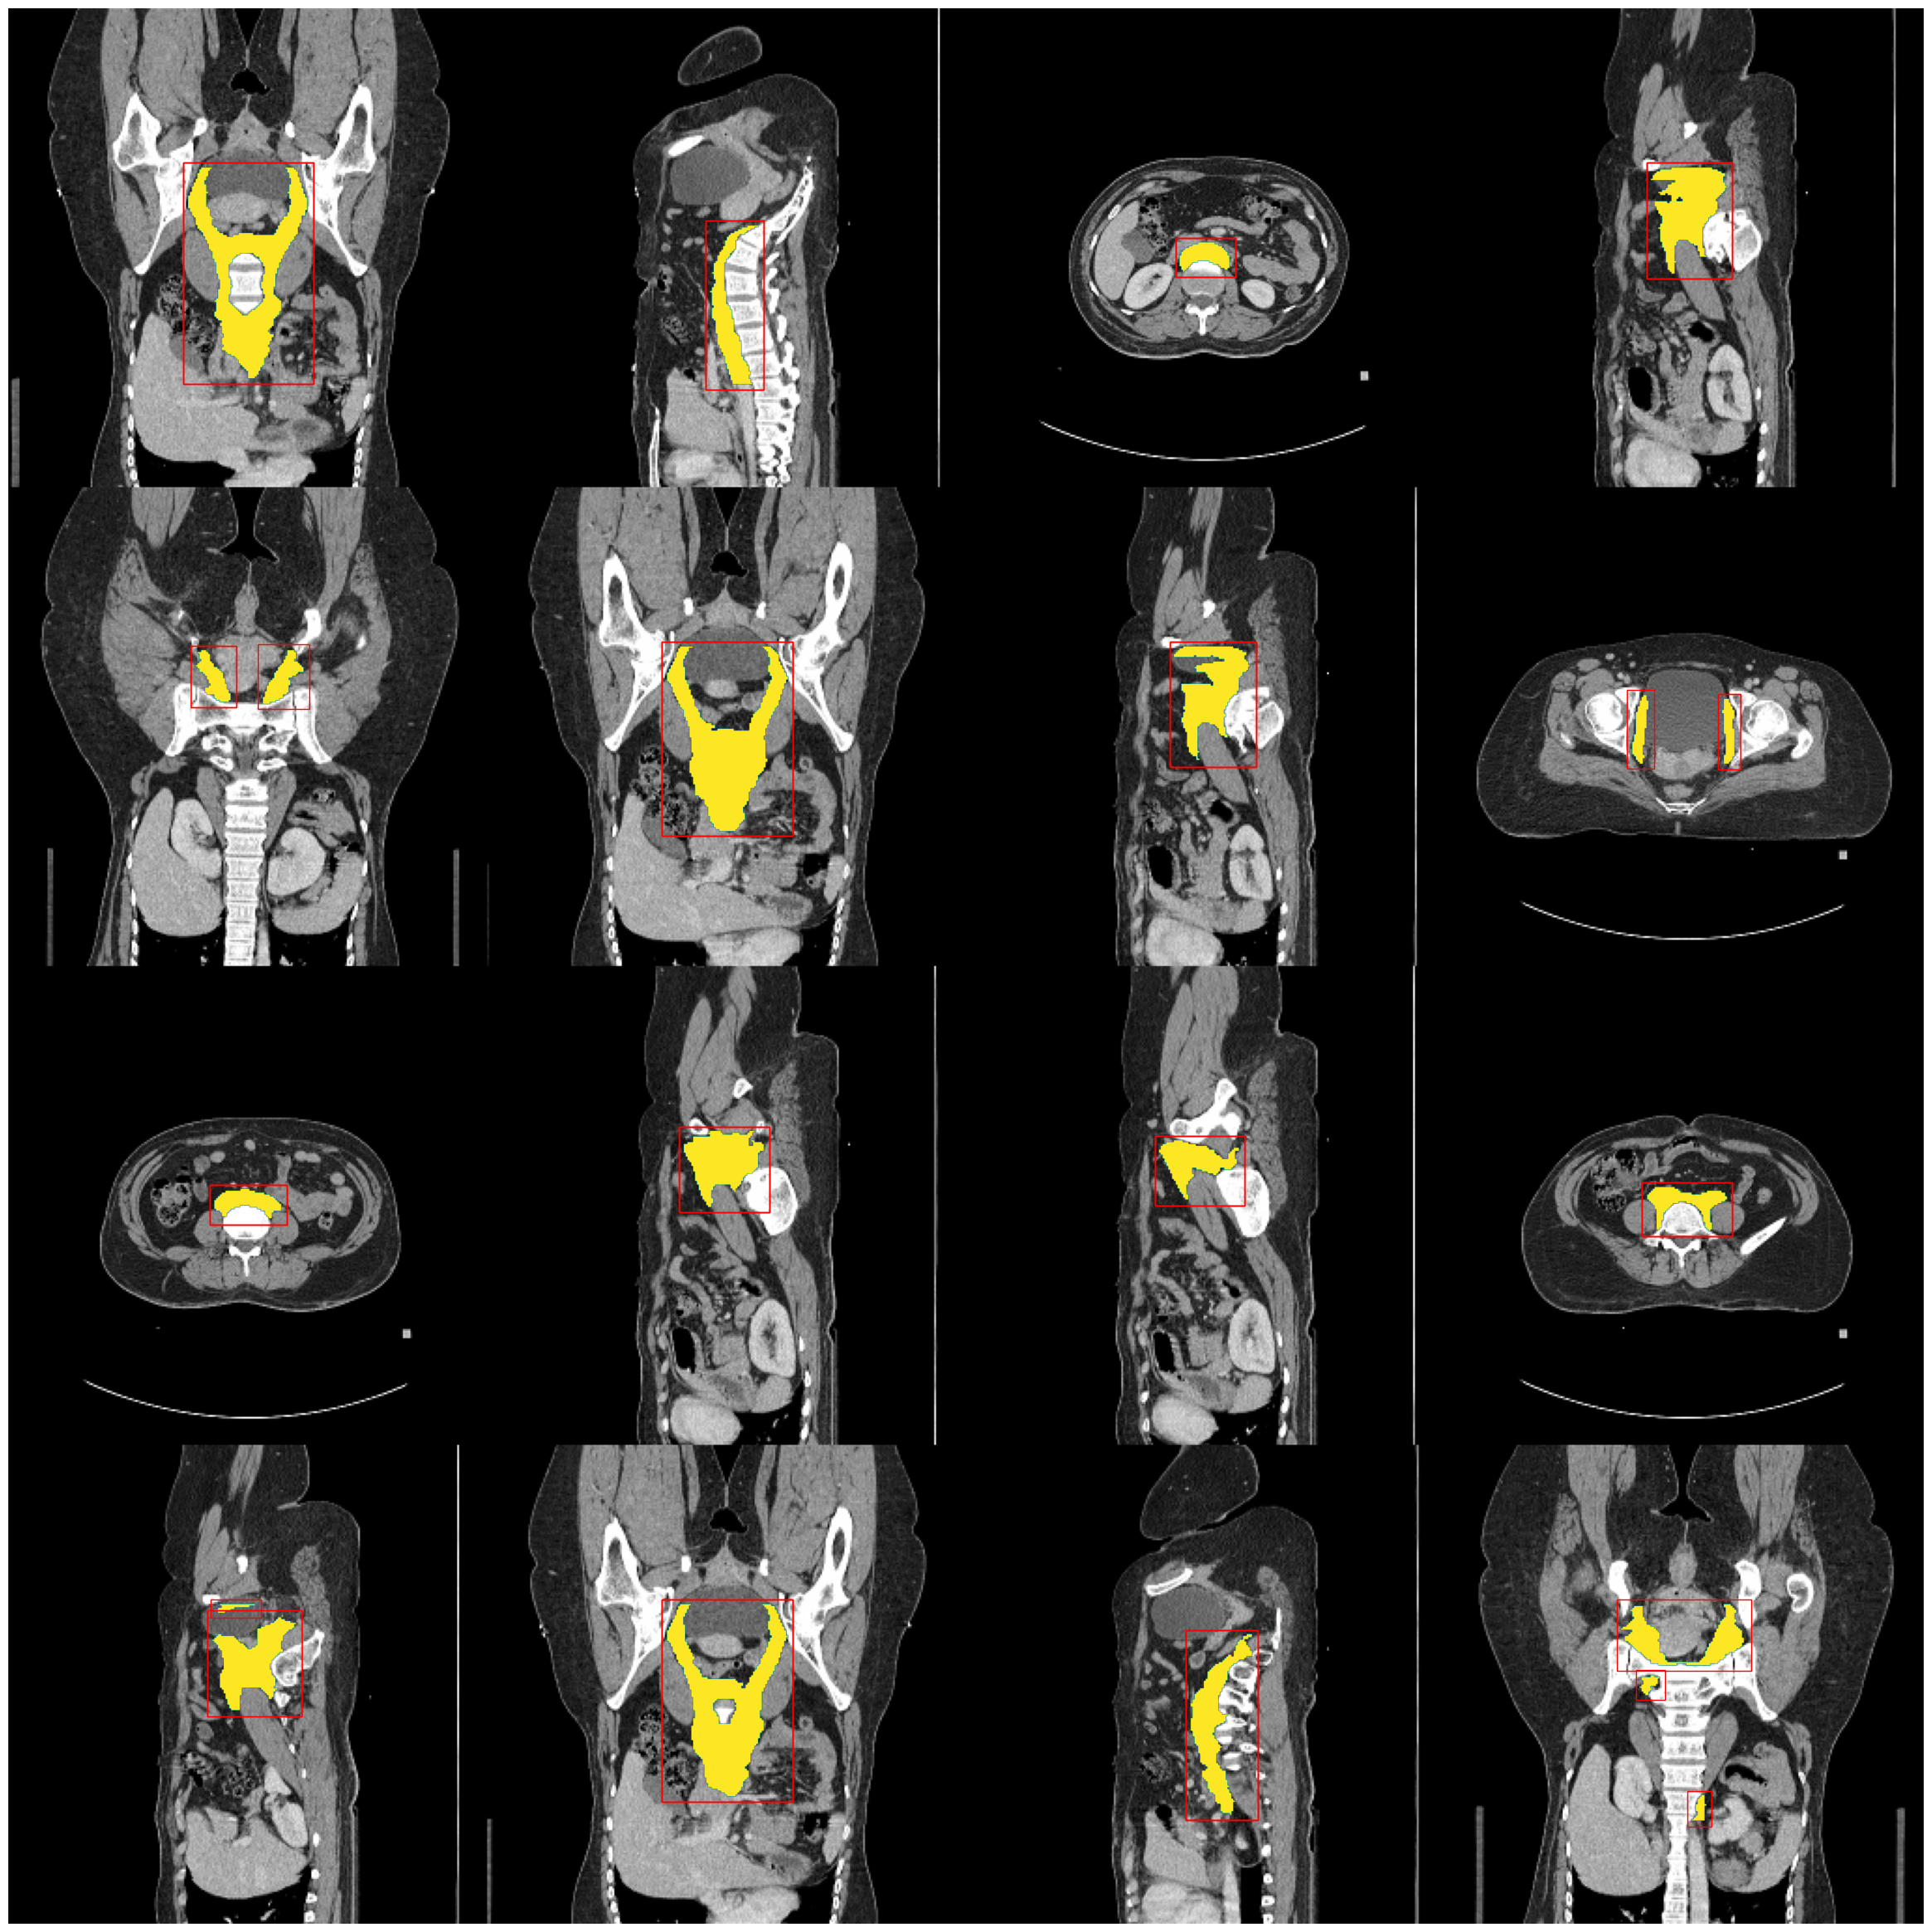

In [31]:
images = F.interpolate(batch['image'], size=(256, 256), mode='bilinear', align_corners=False)

grid_imgs = make_grid(images, nrow=4, padding=0)
grid_gts = make_grid(batch['gt2D'].float(), nrow=4, padding=0)
gts_mask = (grid_gts.sum(dim=0) > 0).float()

plt.figure(figsize=(30, 30))
plt.imshow(grid_imgs.permute(1, 2, 0))
plt.imshow(gts_mask, alpha=gts_mask, cmap='viridis')

shift_x = 0
shift_y = -256
# for i in range(16):

#     shift_y = shift_y + 256 if i % 4 == 0 else shift_y
#     shift_x = shift_x + 256 if i % 4 != 0 else 0

#     coord = batch['coords'][i].squeeze().numpy()
#     for c in coord:
#         x, y = c[0], c[1]
#         x, y = x * 256 / 1024 + shift_x, y * 256 / 1024 + shift_y
#         plt.scatter(x, y, c='r', s=60)

for i in range(16):

    shift_y = shift_y + 256 if i % 4 == 0 else shift_y
    shift_x = shift_x + 256 if i % 4 != 0 else 0

    coord = batch['boxes'][i].squeeze().numpy()
    for c in coord:
        x_min, y_min, x_max, y_max = c[0], c[1], c[2], c[3]
        
        # plot the box
        x, y = x_min, y_min
        x, y = x * 256 / 1024 + shift_x, y * 256 / 1024 + shift_y

        h, w = y_max - y_min, x_max - x_min
        h, w = h * 256 / 1024, w * 256 / 1024

        rectangle = plt.Rectangle((x, y), w, h, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rectangle)

        # plt.scatter(x, y, c='r', s=60)

plt.axis('off')
plt.show()

## Set up Fine-Tuning nn Module

In [32]:
class MedSAM(nn.Module):
    def __init__(self, 
                image_encoder, 
                mask_decoder,
                prompt_encoder,
                freeze_image_encoder=False,
                ):
        super().__init__()
        self.image_encoder = image_encoder
        self.mask_decoder = mask_decoder
        self.prompt_encoder = prompt_encoder

        # freeze prompt encoder
        for param in self.prompt_encoder.parameters():
            param.requires_grad = False
        
        self.freeze_image_encoder = freeze_image_encoder
        if self.freeze_image_encoder:
            for param in self.image_encoder.parameters():
                param.requires_grad = False

    def forward(self, image, point_prompt=None, boxes=None):

        # do not compute gradients for pretrained img encoder and prompt encoder
        with torch.no_grad():
            image_embedding = self.image_encoder(image) # (B, 256, 64, 64)
            # not need to convert box to 1024x1024 grid
            # bbox is already in 1024x1024
            sparse_embeddings, dense_embeddings = self.prompt_encoder(
                points=point_prompt,
                boxes=boxes,
                masks=None,
            )
        low_res_masks, iou_predictions = self.mask_decoder(
            image_embeddings=image_embedding, # (B, 256, 64, 64)
            image_pe=self.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
          ) # (B, 1, 256, 256)

        return low_res_masks

## Helper Classes

In [33]:
class CheckpointHandler():
    def __init__(
            self,
            save_dir: str,
            checkpoint_path: str,
            *args,
            **kwargs
    ):
        self.save_dir = save_dir
        self.checkpoint_path = checkpoint_path
        
        self.lr = kwargs['lr']
        self.weight_decay = kwargs['weight_decay']

    def save_checkpoint(self, model, optimizer, epoch, epoch_loss, best_loss, final):
        """
        Will be guaranteed to save the checkpoint in the save_dir location. If the model
        is at peak performance, it saves it under 'checkpoint_best' otherwise, by default
        it is 'checkpoint_latest'. If specified, the checkpoint is saved under its final
        form and thus replaces 'checkpoint_latest' -> 'checkpoint_final'.
        """

        checkpoint = {
            "model": model.state_dict(),
            "epochs": epoch,
            "optimizer": optimizer.state_dict(),
            "loss": epoch_loss,
            "best_loss": best_loss
        }

        if epoch_loss <= best_loss:
            best_loss = epoch_loss
            torch.save(checkpoint, os.path.join(self.save_dir, 'checkpoint_best.pth'))

        if final:
            torch.save(checkpoint, os.path.join(self.save_dir, 'checkpoint_final.pth'))
            os.remove(os.path.join(self.checkpoint_path, 'checkpoint_latest.pth'))
        else:
            torch.save(checkpoint, os.path.join(self.save_dir, 'checkpoint_latest.pth'))

        return best_loss

    def load_checkpoint(self):
        """
        Loads a checkpoint from the save_dir directory. Assumes this function will be called in the context of continuing training that hasn't finished yet.
        """
        model, optimizer = self.load_base_checkpoint()
        assert self.checkpoint_exists(), "did you check that checkpoint_latest exists?"
        checkpoint = torch.load(os.path.join(self.save_dir, 'checkpoint_latest.pth'))

        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        epoch = checkpoint['epochs']
        best_loss = checkpoint['best_loss']

        return model, optimizer, epoch, best_loss

    def load_base_checkpoint(self):
        sam_model = sam_model_registry["vit_b"](checkpoint=self.checkpoint_path)

        medsam_model = MedSAM(
            image_encoder = sam_model.image_encoder,
            mask_decoder = sam_model.mask_decoder,
            prompt_encoder = sam_model.prompt_encoder,
            freeze_image_encoder = True
        )
        medsam_model = medsam_model.to(device)

        optimizer = optim.AdamW(
            medsam_model.mask_decoder.parameters(),
            lr=self.lr,
            betas=(0.9, 0.999),
            eps=1e-08,
            weight_decay=self.weight_decay
        )

        return medsam_model, optimizer

    def checkpoint_exists(self):
        return os.path.exists(os.path.join(self.save_dir, 'checkpoint_latest.pth'))

    def final_checkpoint_exists(self):
        return os.path.exists(os.path.join(self.save_dir, 'checkpoint_final.pth')) 

In [34]:
class DataLoaderHandler():
    def __init__(self, 
            save_dir, 
            image_dir, 
            gt_dir,
            batch_size,
            num_workers,
            data_aug : bool,
            training_split = 0.8, 
            validation_split = 0.2):

        # Where to save the data splits
        self.save_dir = save_dir
        
        # Where to get image and ground truth info for training
        self.image_dir = image_dir
        self.gt_dir = gt_dir

        # DataLoader parameters
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.data_aug = data_aug
        
        # Splits for validation and training
        assert training_split + validation_split == 1
        self.training_split = training_split
        self.validation_split = validation_split

        # Final dataLoaders
        self.train_loader = None
        self.val_loader = None

    def save_splits_to_json(self, training_image_ids, validation_image_ids):

        data = {
            "training_image_ids": list(training_image_ids),
            "validation_image_ids": list(validation_image_ids)
        }
        with open(os.path.join(self.save_dir, 'data_splits.json'), 'w') as json_file:
            json.dump(data, json_file)

    def load_split_from_json(self):

        with open(os.path.join(self.save_dir, 'data_splits.json'), 'r') as json_file:
            data = json.load(json_file)
        self.training_split = set(data["training_image_ids"])
        self.validation_split = set(data["validation_image_ids"])

    def try_setup_data_split_from_save_with_fallback(self):

        # either load datasplits or setup anew
        if os.path.exists(os.path.join(self.save_dir, 'data_Splits.json')):
            self.load_split_from_json()
        else:
            self.setup_new_data_splits()

    def setup_new_data_splits(self):
        """Setup the data splits from scratch and save"""

        # get the image ids that have been processed. Use gt dir as reference
        axis0_slices = set(map(lambda x : int(re.search(image_id_from_file_name_regex, x).group(1)), os.listdir(os.path.join(self.gt_dir, 'axis0'))))
        axis1_slices = set(map(lambda x : int(re.search(image_id_from_file_name_regex, x).group(1)), os.listdir(os.path.join(self.gt_dir, 'axis1'))))
        axis2_slices = set(map(lambda x : int(re.search(image_id_from_file_name_regex, x).group(1)), os.listdir(os.path.join(self.gt_dir, 'axis2'))))

        if not axis0_slices == axis1_slices == axis2_slices:
            print('[WARNING]: The slices for the anatomy are not consistent across the three axes. Some axese are missing data, please check')
        
        # Split the data into training and validation
        self.training_image_ids = random.sample(list(axis0_slices), int(len(axis0_slices) * self.training_split))
        self.validation_image_ids = list(set(axis0_slices) - set(self.training_image_ids))
        assert set.intersection(set(self.training_image_ids), set(self.validation_image_ids)).__len__() == 0, 'Training and Validation sets are not disjoint'

        # Save the splits in a json file
        self.save_splits_to_json(self.training_image_ids, self.validation_image_ids)

    def setup_dataloaders(self):
        
        self.training_dataset = SAM_Dataset(self.image_dir, self.gt_dir, self.training_image_ids, data_aug = self.data_aug)
        self.validation_dataset = SAM_Dataset(self.image_dir, self.gt_dir, self.validation_image_ids, data_aug = self.data_aug)
        
        # Quick check
        assert set(map(lambda x : int(re.search(image_id_from_file_name_regex, x).group(1)), self.validation_dataset.axis0_imgs)) == set(self.validation_image_ids), 'DataSet incorrectly loaded image ids that don\'t match supplied validation set image ids'
        assert set(map(lambda x : int(re.search(image_id_from_file_name_regex, x).group(1)), self.training_dataset.axis0_imgs)) == set(self.training_image_ids), 'DataSet incorrectly loaded image ids that don\'t match supplied validation set image ids'

        self.train_loader = DataLoader(self.training_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, pin_memory=True)
        self.val_loader = DataLoader(self.validation_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, pin_memory=True)

In [35]:
class LoggingHandler():
    def __init__(self, save_dir):
        # idea, just have a dictionary with the stats that you save at the end of each
        # epoch. You save it down to json at the end. On start, you create a new logging
        # text file where you have info about the running script. IF there doesn't exist a
        # file 'checkpoint_latest_stats.json' then create one. This is where you will load
        # up the stats from the previous run. If there is no such file, then you start
        # from scratch.

        self.per_epoch_stats = dict()
        self.save_dir = save_dir
        self.curr_epoch = -1
        self.curr_epoch_stats = dict()


    def save_stats(self):
        with open(os.path.join(self.save_dir, 'checkpoint_latest_stats.json'), 'w') as json_file:
            json.dump(self.per_epoch_stats, json_file)

    def load_stats(self):
        with open(os.path.join(self.save_dir, 'checkpoint_latest_stats.json'), 'r') as json_file:
            self.per_epoch_stats = json.load(json_file)

    def log_metric(self, key, value, epoch):
        assert self.curr_epoch == epoch
        if key not in self.curr_epoch_stats:
            self.curr_epoch_stats[key] = [value]
        else:
            self.curr_epoch_stats[key].append(value)

    def log(self, line):
        with open(self.loggerName, 'a') as f:
            f.write(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")} - {line}\n')

    def start_new_epoch(self, epoch):
        if self.curr_epoch >= 0:
            self.save_stats()
            self.per_epoch_stats[self.curr_epoch] = self.curr_epoch_stats
        self.curr_epoch = epoch
        self.curr_epoch_stats = {}

        self.curr_epoch_stats['epoch_start'] = time()

    def end_current_epoch(self, epoch):
        assert epoch == self.curr_epoch
        end_time = time()
        self.curr_epoch_stats['epoch_end'] = end_time
        self.curr_epoch_stats['epoch_time'] = end_time - self.curr_epoch_stats['epoch_start']

        self.per_epoch_stats[self.curr_epoch] = self.curr_epoch_stats
        self.save_stats()

    def setup_logger(self):
        # check if the file exists
        if os.path.exists(os.path.join(save_dir, 'checkpoint_latest_stats.json')):
            self.load_stats()
        else:
            os.makedirs(save_dir, exist_ok=True)
            self.save_stats()

        # create a logging file based on datetime
        now = datetime.now()
        self.loggerName = os.path.join(self.save_dir, f'training_{now.strftime("%Y%m%d_%H%M%S")}.log')
        
        with open(self.loggerName, 'w') as f:
            f.write(f"==============================\n")
            f.write(f"Initialised Logger at {now.strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Happy Logging!\n")
            f.write(f"==============================\n")
    
    def plot_stats(self):
        self.load_stats()  # Make sure that the data is current

        # Extract data for plotting
        epochs = []
        dice_loss = []
        ce_loss = []
        val_dice_loss = []
        val_ce_loss = []
        epoch_time = []

        for key, value in self.per_epoch_stats.items():
            epochs.append(int(key))
            dice_loss.append(sum(value['dice_loss']) / len(value['dice_loss']))
            ce_loss.append(sum(value['ce_loss']) / len(value['ce_loss']))
            val_dice_loss.append(sum(value['val_dice_loss']) / len(value['val_dice_loss']))
            val_ce_loss.append(sum(value['val_ce_loss']) / len(value['val_ce_loss']))
            epoch_time.append(value['epoch_time'])

        # Plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

        # Loss plot
        ax1.plot(epochs, dice_loss, label='Dice Loss (Train)', marker='o')
        ax1.plot(epochs, ce_loss, label='CE Loss (Train)', marker='o')
        ax1.plot(epochs, val_dice_loss, label='Dice Loss (Validation)', marker='o')
        ax1.plot(epochs, val_ce_loss, label='CE Loss (Validation)', marker='o')

        ax1.set_title('Losses Over Epochs')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        # Epoch time plot
        ax2.plot(epochs, epoch_time, label='Epoch Time', color='orange', marker='o')

        ax2.set_title('Epoch Time Over Epochs')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Epoch Time (seconds)')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'progress.png'))
        plt.clf()

## Main Training Loop

In [36]:
loggingHandler = LoggingHandler(save_dir)
dataloaderHandler = DataLoaderHandler(save_dir, img_dir, gt_dir, batch_size, num_workers, True)
checkpointHandler = CheckpointHandler(save_dir, checkpoint_path, lr=lr, weight_decay=weight_decay)

In [41]:
class MedSAMTrainer(object):
    def __init__(self, loggingHandler, dataloaderHandler, checkpointHandler, *args, **kwargs):
        self.loggingHandler = loggingHandler
        self.dataloaderHandler = dataloaderHandler
        self.checkpointHandler = checkpointHandler

        self.epochs = kwargs['epochs']
        self.batches_per_epoch = -1 if 'batches_per_epoch' not in kwargs.keys() or kwargs['batches_per_epoch'] is None else kwargs['batches_per_epoch']
        self.resume = kwargs['resume']

        self.dice_loss_fn = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, reduction='mean')
        self.ce_loss_fn = nn.BCEWithLogitsLoss(reduction="mean")

    def run_training(self):
        self.on_train_start()

        for epoch in range(self.current_epoch, self.epochs):
            self.on_epoch_start(epoch)

            pbar = tqdm(range(self.batches_per_epoch))
            for batch_id in pbar:

                batch = next(iter(self.dataloaderHandler.train_loader))
                dice_loss, ce_loss = self.train_step(batch_id, batch)            
                
                pbar.set_description(f"Epoch {epoch}, loss: {dice_loss + ce_loss:.4f}")

            with torch.no_grad():
                self.on_validation_epoch_start()
                val_len = min(len(self.dataloaderHandler.val_loader), self.batches_per_epoch) # in debugging batches might be small, so we go with this.
                pbar = tqdm(range(val_len))
                for batch_id in pbar:

                    batch = next(iter(self.dataloaderHandler.val_loader))
                    dice_loss, ce_loss = self.validation_step(batch_id, batch)
                    
                    pbar.set_description(f"Validating epoch {epoch}, loss: {dice_loss + ce_loss:.4f}")

                self.on_validation_epoch_end()

            self.on_epoch_end(epoch)

    def on_train_start(self):
        self.loggingHandler.setup_logger()

        torch.cuda.empty_cache()

        self.loggingHandler.log('Setting up dataloaders')
        self.dataloaderHandler.try_setup_data_split_from_save_with_fallback()
        self.dataloaderHandler.setup_dataloaders()

        self.batches_per_epoch = len(self.dataloaderHandler.train_loader) if self.batches_per_epoch == -1 else self.batches_per_epoch

        self.loggingHandler.log('Setting up models')
        self.model, self.optimizer, self.current_epoch, self.best_loss = None, None, 0, 1e10
        if self.checkpointHandler.final_checkpoint_exists() and self.resume:
            self.loggingHandler.log('We have already trained this model to completion')
            exit(1)
        elif self.checkpointHandler.checkpoint_exists() and self.resume:
            self.loggingHandler.log('Resume is true and a checkpoint exists, we resume')
            self.model, self.optimizer, self.current_epoch, self.best_loss = self.checkpointHandler.load_checkpoint()
            self.current_epoch += 1
            self.loggingHandler.log(f'Resuming at epoch: {self.current_epoch}')
        else:
            self.loggingHandler.log('Setting up a fresh start model')
            self.model, self.optimizer = self.checkpointHandler.load_base_checkpoint()

    def on_epoch_start(self, epoch):
        self.loggingHandler.log('=====================================')
        self.loggingHandler.log('Setting up a new epoch for the logger')
        self.loggingHandler.start_new_epoch(epoch)
        self.current_epoch = epoch

    def train_step(self, step, batch):
        self.loggingHandler.log(f'Starting epoch {self.current_epoch} and step {step} out of {self.batches_per_epoch}')

        # Get data
        image = batch["image"].to(device)
        gt2D = batch["gt2D"].to(device)
        # coords_torch = batch["coords"].squeeze().to(device) # ([B, Ps, 2])
        boxes_torch = batch["boxes"].squeeze().to(device) # ([B, Ps, 4])

        # self.optimizer.zero_grad()
        # labels_torch = torch.ones(coords_torch.shape[0], coords_torch.shape[1]).long() # (B, Ps)
        # coords_torch, labels_torch = coords_torch.to(device), labels_torch.to(device)
        # point_prompt = (coords_torch, labels_torch)
        medsam_lite_pred = self.model(image, None, boxes_torch)

        dice_loss = self.dice_loss_fn(medsam_lite_pred, gt2D)
        ce_loss = self.ce_loss_fn(medsam_lite_pred, gt2D.float())

        loss = dice_loss + ce_loss
        
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        self.loggingHandler.log(f'[TRAINING]:   Received dice loss: {dice_loss.item()} with cross entropy loss: {ce_loss.item()}')
        self.loggingHandler.log_metric('dice_loss', dice_loss.item(), self.current_epoch)
        self.loggingHandler.log_metric('ce_loss', ce_loss.item(), self.current_epoch)

        return dice_loss.item(), ce_loss.item()

    def on_epoch_end(self, epoch):
        self.loggingHandler.end_current_epoch(epoch)

        # Get reduced loss
        dice_loss = self.loggingHandler.curr_epoch_stats['dice_loss']
        ce_loss = self.loggingHandler.curr_epoch_stats['ce_loss']
        epoch_loss_reduced = (sum(dice_loss) + sum(ce_loss)) / (len(dice_loss) + len(ce_loss))

        if epoch_loss_reduced < self.best_loss:
            self.best_loss = epoch_loss_reduced
        
        self.checkpointHandler.save_checkpoint(self.model, self.optimizer, epoch, epoch_loss_reduced, self.best_loss, final=False)

        self.loggingHandler.plot_stats()

        self.loggingHandler.log('=====================================')

    def on_validation_epoch_start(self):
        self.loggingHandler.log('Starting validation epoch')

    def validation_step(self, batch_id, batch):
        self.loggingHandler.log(f'Validation step {batch_id} out of {min(len(self.dataloaderHandler.val_loader), self.batches_per_epoch)}')

        image = batch["image"].to(device)
        gt2D = batch["gt2D"].to(device)
        coords_torch = batch["coords"].to(device)

        labels_torch = torch.ones(coords_torch.shape[0]).long().to(device)
        labels_torch = labels_torch.unsqueeze(1)

        point_prompt = (coords_torch, labels_torch)
        medsam_lite_pred = self.model(image, point_prompt)

        dice_loss = self.dice_loss_fn(medsam_lite_pred, gt2D)
        ce_loss = self.ce_loss_fn(medsam_lite_pred, gt2D.float())

        self.loggingHandler.log(f'[VALIDATION]: Received dice loss: {dice_loss.item()} with cross entropy loss: {ce_loss.item()}')
        self.loggingHandler.log_metric('val_dice_loss', dice_loss.item(), self.current_epoch)
        self.loggingHandler.log_metric('val_ce_loss', ce_loss.item(), self.current_epoch)

        return dice_loss.item(), ce_loss.item()

    def on_validation_epoch_end(self):
        
        # Get reduced loss
        dice_loss = self.loggingHandler.curr_epoch_stats['val_dice_loss']
        ce_loss = self.loggingHandler.curr_epoch_stats['val_ce_loss']
        epoch_loss_reduced = (sum(dice_loss) + sum(ce_loss)) / (len(dice_loss) + len(ce_loss))

        self.loggingHandler.log('Validation epoch ended')
        self.loggingHandler.log(f'Average loss: {epoch_loss_reduced}')

In [42]:
myTrainer = MedSAMTrainer(
    loggingHandler, 
    dataloaderHandler, 
    checkpointHandler,
    epochs=epochs,
    resume=resume,
    batches_per_epoch=batches_per_epoch
)
# myTrainer.run_training()

In [43]:
myTrainer.on_train_start()
myTrainer.on_epoch_start(-1)

Dataset size (26.4 GiB) exceeds cache limit (15 GiB). Allocating space to cache 15359 / 27002 samples.
Dataset size (6.5 GiB) fits in cache limit (15 GiB). Allocating space to cache all 6678 samples.


In [44]:
batch = next(iter(myTrainer.dataloaderHandler.train_loader))

In [45]:
myTrainer.train_step(-1, batch)